In [1]:
from super_gradients.training import models
import cv2
import sys
sys.path.append('..')
from anns import Detection
import matplotlib.pyplot as plt
import numpy as np


[2023-09-24 19:06:37] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/fer/sg_logs/console.log


2023-09-24 19:06:38.831573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 19:06:39.698846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/fer/miniconda3/envs/futstats/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-24 19:06:41] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-24 19:06:41] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-24 19:06:41] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-24 19:06:41] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
CLASSES = [
    "1",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "c",
]
NUM_CLASES = len(CLASSES)

In [4]:
model = models.get("yolo_nas_l",
                        num_classes=NUM_CLASES,
                        checkpoint_path="/home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth")

[2023-09-24 19:06:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth EMA checkpoint.


In [5]:
img = cv2.cvtColor(cv2.imread('field.png'), cv2.COLOR_BGR2RGB)
field = cv2.cvtColor(cv2.imread('field_2d.jpg'), cv2.COLOR_BGR2RGB)


plt.imshow(field)

In [6]:
results = list(model.predict(img, conf=0.25))[0]
detections = Detection.from_yoloNas(pred=results)

[2023-09-24 19:06:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [7]:
detections

[Detection(rect=Rect(x=6.277492523193359, y=447.4559020996094, width=28.667518615722656, height=36.916351318359375), class_id=6, class_name='15', confidence=0.7045174837112427, tracker_id=None, color=None),
 Detection(rect=Rect(x=788.0101928710938, y=210.60060119628906, width=17.2198486328125, height=21.641693115234375), class_id=15, class_name='9', confidence=0.6821118593215942, tracker_id=None, color=None),
 Detection(rect=Rect(x=1289.7734375, y=437.33160400390625, width=23.4703369140625, height=31.571441650390625), class_id=3, class_name='12', confidence=0.6706815361976624, tracker_id=None, color=None),
 Detection(rect=Rect(x=892.4678955078125, y=259.5836486816406, width=17.4552001953125, height=20.681121826171875), class_id=1, class_name='10', confidence=0.6313509941101074, tracker_id=None, color=None),
 Detection(rect=Rect(x=1105.309814453125, y=238.08750915527344, width=16.2698974609375, height=17.640106201171875), class_id=13, class_name='7', confidence=0.6302385926246643, track

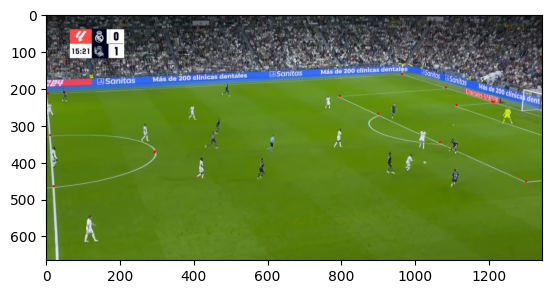

In [8]:
field = cv2.cvtColor(cv2.imread('field_2d.jpg'), cv2.COLOR_BGR2RGB)

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)


plt.imshow(points)

In [37]:
POINT2POINT2D = {
    "1" : (60, 60),
    "2" : (310, 60),
    "3" : (520, 60),
    "4" : (850, 60),
    "5" : (1050, 60),
    "6" : (1300, 60),
    "7" : (520, 160),
    "8" : (850, 160),
    "9" : (310,360),
    "10" : (550,360),
    "11" : (820, 360),
    "12" : (1050, 360),
    "13": (60, 1020),
    "14" : (680, 1020),
    "15" : (860, 1020),
    "16" : (1300, 1020),
    "c" : (680, 850),
}

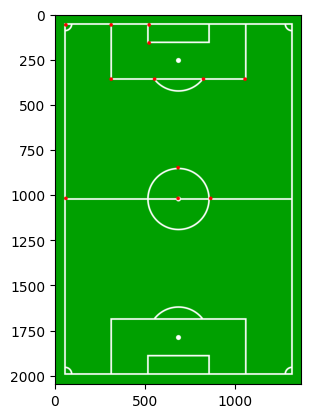

In [42]:
src_points = []
dst_points = []


anns_2d = field.copy()


for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    if str(detection.class_name) in POINT2POINT2D:
        points_2d = POINT2POINT2D[str(detection.class_name)]
        src_points.append(center)
        dst_points.append(points_2d)
        anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)


plt.imshow(anns_2d)

In [76]:
H, status = cv2.findHomography(np.array(src_points), np.array(dst_points))


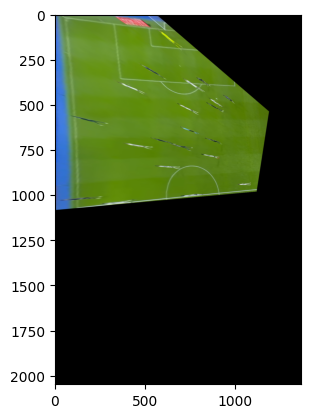

In [77]:
im_out = cv2.warpPerspective(img, H, (field.shape[1],field.shape[0]))
plt.imshow(im_out)

In [90]:
BALL = (1035, 400)
ball_pts = np.array([BALL],np.float32).reshape(-1,1,2)

In [91]:
from mask_utils import get_perspective_transform

In [92]:
pred_homo = get_perspective_transform(np.array(src_points),np.array(dst_points))

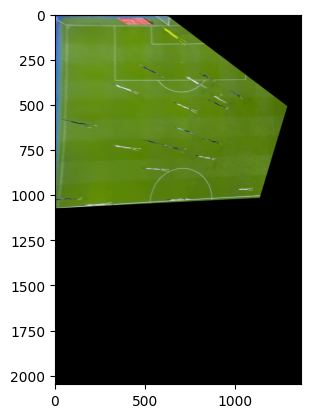

In [93]:
im_out = cv2.warpPerspective(img, pred_homo, (field.shape[1],field.shape[0]))
plt.imshow(im_out)

In [94]:
ball_pts_2d = cv2.perspectiveTransform(ball_pts,pred_homo)
ball_pts_2d = ball_pts_2d.astype(int)

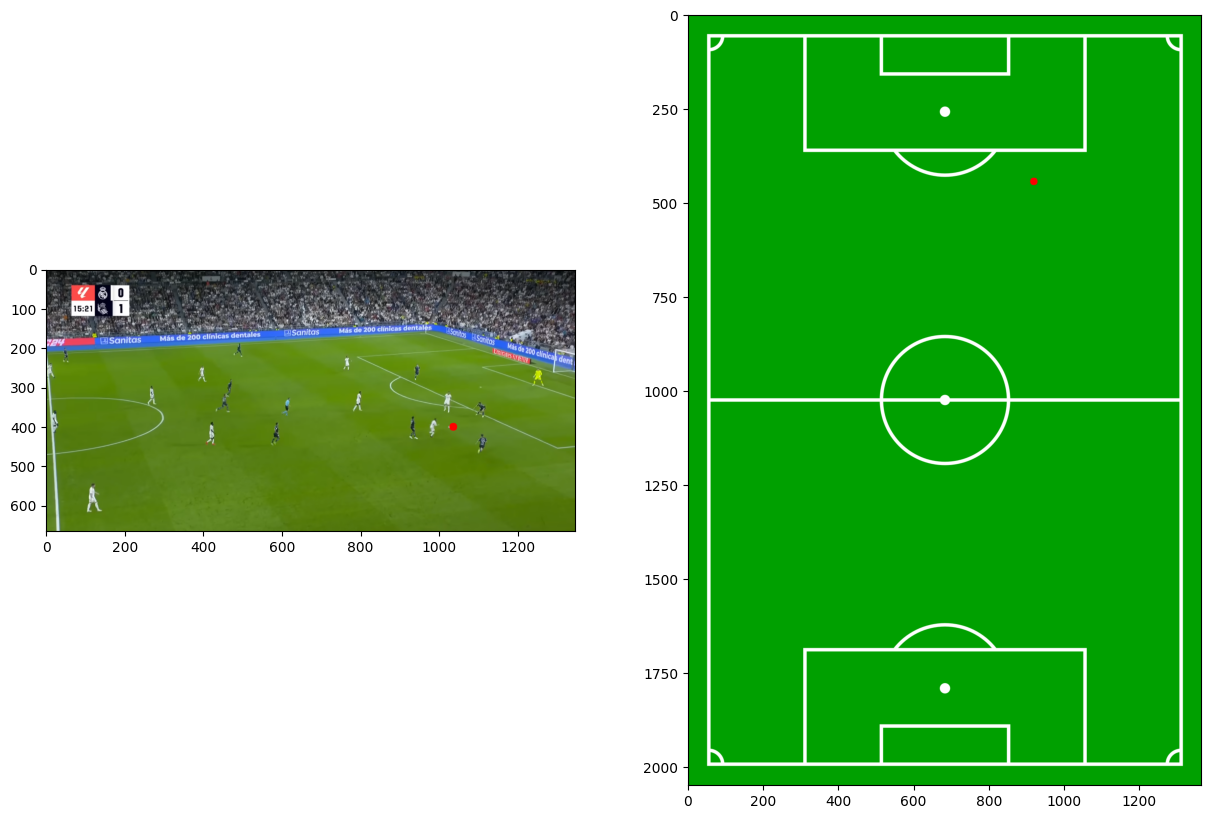

In [95]:
ball = img.copy()
ball = cv2.circle(ball, BALL, 10, (255, 0, 0), -1)

ball_2d = field.copy()
ball_2d = cv2.circle(ball_2d, tuple(ball_pts_2d[0][0]), 10, (255, 0, 0), -1)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(ball)
ax[1].imshow(ball_2d)